In [1]:

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
import random
import math
from sklearn.model_selection import train_test_split

In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


In [4]:
image_transforms = transforms.Compose(
         [transforms.ToTensor(),
         transforms.CenterCrop(28),
         transforms.Normalize((0.5), (0.5))]
)

In [5]:
batchsize = 32
rowsize = 28
colsize = 28
inchannels = 3
fc_size = 128
no_classes = 2
epochs = 100

In [6]:
download_url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data")
cols = np.arange(0,58,1)
df = pd.read_csv(download_url,names=cols)
pd.set_option("display.max.rows", None)
data = pd.DataFrame(df).to_numpy()
num = len(data)
feat = len(data[0])-1

In [7]:
X = data[:,0:feat]
label = data[:,-1]
Xcopy = X
labelcopy = label
print(label)
for i in range(int(len(label))):
  label[i] = random.choice([0,1])

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=42) 
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

[1. 1. 1. ... 0. 0. 0.]


In [8]:
print(len(X_train))

3680


In [9]:
class IOC_MLP(nn.Module):
  def __init__(self,rowsize,colsize,fc_size,inchannels,no_classes):
    super(IOC_MLP, self).__init__()
    self.fc1 = nn.Linear(feat,fc_size)
    self.batchnorm1 = nn.BatchNorm1d(fc_size)
    self.fc2 = nn.Linear(fc_size,fc_size)
    self.batchnorm2 = nn.BatchNorm1d(fc_size)
    self.fc3 = nn.Linear(fc_size,fc_size)
    self.batchnorm3 = nn.BatchNorm1d(fc_size)
    self.fc4 = nn.Linear(fc_size,no_classes)


  def forward(self, x):
    x = torch.flatten(x)
    x = x.view(-1,feat)
    x = F.elu(self.fc1(x))
    x = self.batchnorm1(x)
    x = F.elu(self.fc2(x))
    x = self.batchnorm2(x)
    x = F.elu(self.fc3(x))
    x = self.batchnorm3(x)
    x = self.fc4(x)
    return x

In [10]:
class NN(nn.Module):
  def __init__(self,rowsize,colsize,fc_size,inchannels,no_classes):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(feat,fc_size)
    self.batchnorm1 = nn.BatchNorm1d(fc_size)
    self.fc2 = nn.Linear(fc_size,fc_size)
    self.batchnorm2 = nn.BatchNorm1d(fc_size)
    self.fc3 = nn.Linear(fc_size,fc_size)
    self.batchnorm3 = nn.BatchNorm1d(fc_size)
    self.fc4 = nn.Linear(fc_size,no_classes)


  def forward(self, x):
    x = torch.flatten(x)
    x = x.view(-1,feat)
    x = F.relu(self.fc1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.fc2(x))
    x = self.batchnorm2(x)
    x = F.relu(self.fc3(x))
    x = self.batchnorm3(x)
    x = self.fc4(x)
    return x

In [11]:
ioc_model = IOC_MLP(rowsize,colsize,fc_size,inchannels,no_classes).to(device)
nn_model = NN(rowsize,colsize,fc_size,inchannels,no_classes).to(device)
# model = SimpleAlex(no_classes).to(device)

In [12]:
ioc_optimizer = torch.optim.Adam(ioc_model.parameters(),lr= 0.0001)
criterion = nn.CrossEntropyLoss().to(device)
nn_optimizer = torch.optim.Adam(nn_model.parameters(),lr= 0.0001)

In [13]:
a = torch.zeros(2)
b = torch.zeros(2)
a[0]=1
b[1]=1
m = {0:a,1:b}

In [14]:
train_ioc = []
train_nn = []
test_ioc = 0
test_ioc = 0

In [15]:
# def training(model,traindata,testdata)
# print("Choose the weight Variation number, (1 for clipping negative weight to zero , 2 for taking absolute of weights , 3 for exponentiation of weights")
# a = input()
for i in range(epochs):
  Loss = 0
  num_correct=0
  tot = 0
  count=0
  for d in range(int(len(X_train)/batchsize)):
    # iterating through every batch
    ls = np.arange(count,count+batchsize,1)
    ls = torch.from_numpy(ls)
    x_data = X_train[ls].to(device)
    labels = y_train[ls].to(device)
    ioc_optimizer.zero_grad()
    outputs = ioc_model(x_data).to(device)
    _, pred = torch.max(outputs.data, 1)
    num_correct += (pred == labels).sum().item()
    tot += labels.size(0)
    onehot_labels = torch.zeros((batchsize,2))
    for i in range(batchsize):
      onehot_labels[i] = m[int(labels[i])]                                         
    onehot_labels = onehot_labels.to(device)
    loss = criterion(outputs, onehot_labels)
    loss.backward()
    ioc_optimizer.step()
    Loss += loss
    count+=batchsize
    for w in ioc_model.parameters():
      p = w
      torch.where(w > 0, w, torch.exp(p))
  train_ioc.append(num_correct/tot)
  print("Train Accuracy for exponentiation of negative weights: ",num_correct/tot)
  print("Loss: ",loss.item())

Train Accuracy for exponentiation of negative weights:  0.5122282608695652
Loss:  0.7243381142616272
Train Accuracy for exponentiation of negative weights:  0.5230978260869565
Loss:  0.7082328796386719
Train Accuracy for exponentiation of negative weights:  0.5388586956521739
Loss:  0.694148600101471
Train Accuracy for exponentiation of negative weights:  0.5521739130434783
Loss:  0.681691586971283
Train Accuracy for exponentiation of negative weights:  0.5584239130434783
Loss:  0.67063307762146
Train Accuracy for exponentiation of negative weights:  0.5652173913043478
Loss:  0.6621412038803101
Train Accuracy for exponentiation of negative weights:  0.5698369565217392
Loss:  0.6544000506401062
Train Accuracy for exponentiation of negative weights:  0.5728260869565217
Loss:  0.6470270156860352
Train Accuracy for exponentiation of negative weights:  0.5790760869565217
Loss:  0.6397922039031982
Train Accuracy for exponentiation of negative weights:  0.5826086956521739
Loss:  0.63329446315

In [16]:
with torch.no_grad():
    correct = 0
    total = 0
    count=0
    for d in range(int(len(X_test)/batchsize)):
        ls = np.arange(count,count+batchsize,1)
        ls = torch.from_numpy(ls)
        x_data = X_test[ls].to(device)
        labels = y_test[ls].to(device)
        outputs = ioc_model(x_data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        count+=batchsize
    test_ioc = 100*correct/total
    print("Test Accuracy on exponentiation of negative weights For IOC Model : ",100 * correct / total)



Test Accuracy on exponentiation of negative weights For IOC Model :  50.669642857142854


In [17]:
# def training(model,traindata,testdata)
# print("Choose the weight Variation number, (1 for clipping negative weight to zero , 2 for taking absolute of weights , 3 for exponentiation of weights")
# a = input()
for i in range(epochs):
  Loss = 0
  num_correct=0
  tot = 0
  count=0
  for d in range(int(len(X_train)/batchsize)):
    # iterating through every batch
    ls = np.arange(count,count+batchsize,1)
    ls = torch.from_numpy(ls)
    x_data = X_train[ls].to(device)
    labels = y_train[ls].to(device)
    nn_optimizer.zero_grad()
    outputs = nn_model(x_data).to(device)
    _, pred = torch.max(outputs.data, 1)
    num_correct += (pred == labels).sum().item()
    tot += labels.size(0)
    onehot_labels = torch.zeros((batchsize,2))
    for i in range(batchsize):
      onehot_labels[i] = m[int(labels[i])]                                         
    onehot_labels = onehot_labels.to(device)
    loss = criterion(outputs, onehot_labels)
    loss.backward()
    nn_optimizer.step()
    Loss += loss
    count+=batchsize
  train_nn.append(num_correct/tot)
  
  print("Train Accuracy for NN: ",num_correct/tot)
  print("Loss: ",loss.item())

Train Accuracy for NN:  0.5046195652173913
Loss:  0.7459298372268677
Train Accuracy for NN:  0.5364130434782609
Loss:  0.6989479064941406
Train Accuracy for NN:  0.5733695652173914
Loss:  0.6748161315917969
Train Accuracy for NN:  0.5904891304347826
Loss:  0.6611651182174683
Train Accuracy for NN:  0.6073369565217391
Loss:  0.6537641286849976
Train Accuracy for NN:  0.6176630434782608
Loss:  0.6469166874885559
Train Accuracy for NN:  0.6301630434782609
Loss:  0.62863689661026
Train Accuracy for NN:  0.6467391304347826
Loss:  0.6141177415847778
Train Accuracy for NN:  0.6616847826086957
Loss:  0.6161836385726929
Train Accuracy for NN:  0.6660326086956522
Loss:  0.612356424331665
Train Accuracy for NN:  0.6817934782608696
Loss:  0.5982841849327087
Train Accuracy for NN:  0.6902173913043478
Loss:  0.5855699777603149
Train Accuracy for NN:  0.7002717391304348
Loss:  0.5854202508926392
Train Accuracy for NN:  0.70625
Loss:  0.5653283596038818
Train Accuracy for NN:  0.7146739130434783
Loss:

In [18]:
with torch.no_grad():
    correct = 0
    total = 0
    count=0
    for d in range(int(len(X_test)/batchsize)):
        ls = np.arange(count,count+batchsize,1)
        ls = torch.from_numpy(ls)
        x_data = X_test[ls].to(device)
        labels = y_test[ls].to(device)
        outputs = nn_model(x_data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        count+=batchsize
    test_nn = 100*correct/total
    print("Test Accuracy For NN Model : ",100 * correct / total)



Test Accuracy For NN Model :  52.00892857142857


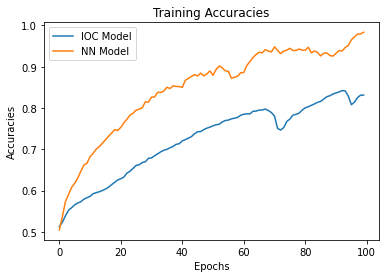

In [19]:
import matplotlib.pyplot as plt
epoch_numbers = np.arange(0,epochs,1)
plt.title("Training Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.plot(epoch_numbers,train_ioc,label='IOC Model')
plt.plot(epoch_numbers,train_nn,label='NN Model')     
plt.legend()
plt.show()           

In [20]:
print("Generalization Gap for NN Model",(train_nn[len(train_nn)-1]*100)-test_nn)
print("Generalization Gap for IOC Model",(train_ioc[len(train_ioc)-1]*100)-test_ioc)

Generalization Gap for NN Model 46.33346273291926
Generalization Gap for IOC Model 32.455357142857146
